In [26]:
import matplotlib
import pandas as pd
import numpy as np
#import cbor2
import librosa
from scipy.signal import butter
from scipy.signal import lfilter
from scipy.signal import filtfilt
from scipy.signal import freqz
from scipy.signal import sosfreqz
import matplotlib.pyplot as plt
#import plotly.express as px
import IPython.display as ipd
import scipy.signal as signal

In [70]:
def compute_fft(s, sampling_rate, n = None, scale_amplitudes = True):
    '''Computes an FFT on signal s using numpy.fft.fft.
    
       Parameters:
        s (np.array): the signal
        sampling_rate (num): sampling rate
        n (integer): If n is smaller than the length of the input, the input is cropped. If n is 
            larger, the input is padded with zeros. If n is not given, the length of the input signal 
            is used (i.e., len(s))
        scale_amplitudes (boolean): If true, the spectrum amplitudes are scaled by 2/len(s)
    '''
    if n == None:
        n = len(s)
        
    fft_result = np.fft.fft(s, n)
    num_freq_bins = len(fft_result)
    fft_freqs = np.fft.fftfreq(num_freq_bins, d = 1 / sampling_rate)
    half_freq_bins = num_freq_bins // 2

    fft_freqs = fft_freqs[:half_freq_bins]
    fft_result = fft_result[:half_freq_bins]
    fft_amplitudes = np.abs(fft_result)
    
    if scale_amplitudes is True:
        fft_amplitudes = 2 * fft_amplitudes / (len(s))
    
    return (fft_freqs, fft_amplitudes);


def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='lowpass', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    
    
    
    #y = lfilter(b, a, data)
    y = filtfilt(b, a, data)
    return y;


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y

def cbor2csv(filename):
    '''
    Function to convert cbro files to csv.
    Depends on: Numpy, Pandas and Cbor2 library
    Input: Filename with cbor
    Output: Stores the same name csv file
    '''
    with open(filename, 'rb') as fp:
        obj = cbor2.load(fp)  
        pd.DataFrame(data=np.array(obj['payload']['values']),columns=['X','Y','Z']).to_csv(filename.split('.')[0]+".csv", index=False)



## LP filter using numerator/denominator method

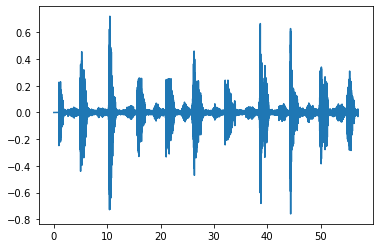

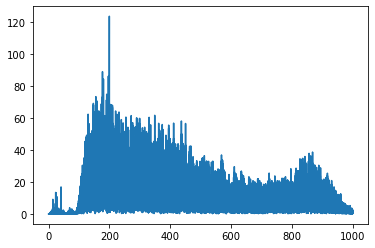

In [55]:
#load the audio data
fs=2000
y_o, fs = librosa.load("data/audio/audacity_recorded-mask-tidal-breathing.wav", sr=2000)
t_o = [s/fs for s in range(0,len(y_o))]

plt.plot(t_o,y_o)
plt.show()
F, A = compute_fft(y_o, fs, scale_amplitudes=False)
plt.plot(F, A)
plt.show()

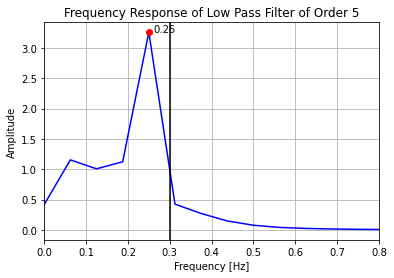

In [126]:
# Plot the frequency response.
order = 5
cutoff = 0.3
b, a = butter_lowpass(cutoff, fs, order)
w, h = freqz(b, a, worN=16000)

fig, ax = plt.subplots()
freqInResponse = 0.5*fs*w/np.pi
ax.plot(freqInResponse, np.abs(h), 'b')
ax.plot(freqInResponse[np.argmax(np.abs(h))],max(np.abs(h)),'ro') 
ax.annotate(freqInResponse[np.argmax(np.abs(h))], (freqInResponse[np.argmax(np.abs(h))]+0.01, max(np.abs(h))))
ax.axvline(cutoff, color='k')
#ax[0,1].set_xlim(0, 0.5*fs)
ax.set_title("Frequency Response of Low Pass Filter of Order {}".format(order))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_xlim([0,0.8])
ax.grid()


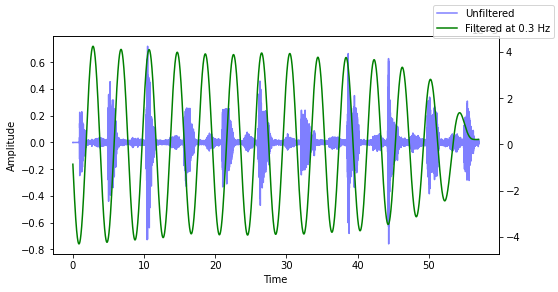

In [121]:
y_f = butter_lowpass_filter(y_o, 0.3, 2000, order=5)
t_f = [s/fs for s in range(0,len(y_f))]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax2 = ax.twinx()
ax.plot(t_o,y_o, 'b-', label='Unfiltered', alpha=0.5)
ax2.plot(t_f,y_f, 'g-', label='Filtered at 0.3 Hz')

#ax[0].plot(t_o,y_o)
#ax[1].plot(t_f,y_f)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
fig.legend()

## LP filter using SOS method

In [6]:
from scipy.fft import fft, fftfreq

(0.0, 1000.0)

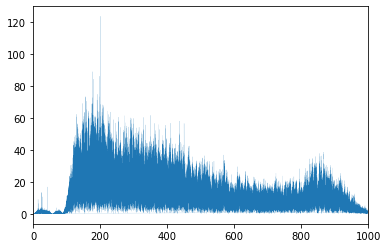

In [58]:
yf = fft(y_o)
xf = fftfreq(len(y_o), 1 / fs)

plt.plot(xf, np.abs(yf), lw=0.1)
plt.xlim((0, 1000))

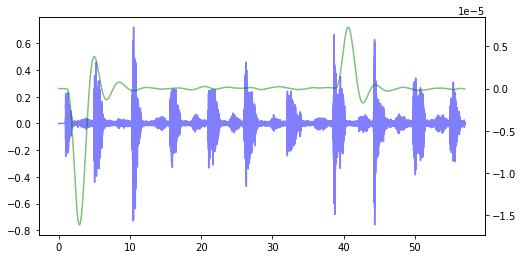

In [127]:
order = 5
cutoff = 0.3
normal_cutoff = cutoff/(0.5*fs)
sos = signal.butter(order, cutoff, 'lp', fs=fs, output='sos')
filtered = signal.sosfilt(sos, y_o)
t_f = [s/fs for s in range(0,len(filtered))]

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax2 = ax.twinx()
ax.plot(t_o,y_o, 'b-', label='Unfiltered', alpha=0.5)
ax2.plot(t_f,filtered, 'g-', label='Filtered at 0.3 Hz', alpha=0.5)

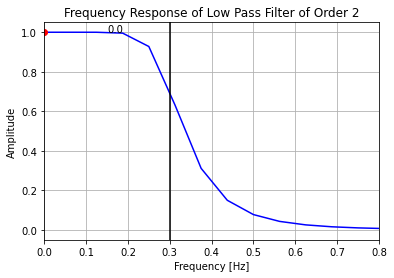

In [105]:
w, h = sosfreqz(sos,worN=16000)
fig, ax = plt.subplots()
freqInResponse = 0.5*fs*w/np.pi
ax.plot(freqInResponse, np.abs(h), 'b')
ax.plot(freqInResponse[np.argmax(np.abs(h))],max(np.abs(h)),'ro') 
ax.annotate(freqInResponse[np.argmax(np.abs(h))], (freqInResponse[np.argmax(np.abs(h))]+0.15, max(np.abs(h))))
ax.axvline(cutoff, color='k')
#ax.set_xlim(0, 0.5*fs)
ax.set_xlim([0,cutoff+0.5])
ax.set_title("Frequency Response of Low Pass Filter of Order {}".format(order))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')

ax.grid()


## Using bandpass using numerator/denominator method

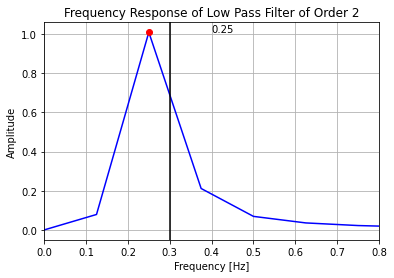

In [128]:
order = 2
low_cut = 0.2
high_cut = 0.3
fs = fs
b, a = butter_bandpass(low_cut, high_cut, fs, order)
w, h = freqz(b, a, worN=8000)
fig, ax = plt.subplots()
freqInResponse = 0.5*fs*w/np.pi
ax.plot(freqInResponse, np.abs(h), 'b')
ax.plot(freqInResponse[np.argmax(np.abs(h))],max(np.abs(h)),'ro') 
ax.annotate(freqInResponse[np.argmax(np.abs(h))], (freqInResponse[np.argmax(np.abs(h))]+0.15, max(np.abs(h))))
ax.axvline(cutoff, color='k')
#ax[0,1].set_xlim(0, 0.5*fs)
ax.set_title("Frequency Response of Low Pass Filter of Order {}".format(order))
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Amplitude')
ax.set_xlim([0,0.8])
ax.grid()

#y_f_bp = butter_bandpass_filter(y_o, 0.2, 0.3, fs, order=5):

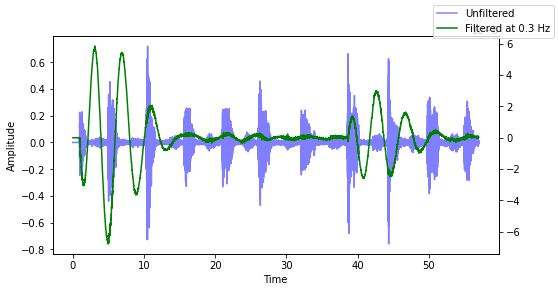

In [119]:
y_f = butter_bandpass_filter(y_o, low_cut, high_cut, fs, order=order)
t_f = [s/fs for s in range(0,len(y_f))]

fig, ax = plt.subplots(1,1,figsize=(8,4))

ax2 = ax.twinx()
ax.plot(t_o,y_o, 'b-', label='Unfiltered', alpha=0.5)
ax2.plot(t_f,y_f, 'g-', label='Filtered at 0.3 Hz')

#ax[0].plot(t_o,y_o)
#ax[1].plot(t_f,y_f)
ax.set_xlabel('Time')
ax.set_ylabel('Amplitude')
fig.legend()